In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pymannkendall import original_test
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sktime.forecasting.croston import Croston
from sktime.forecasting.base import ForecastingHorizon
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

Importing plotly failed. Interactive plots will not work.


Functions to Analyze Trends and Group by Margin

In [2]:
def analyze_trend(df, level_col='product_id', date_col='sale_date', value_col='total'):
    """
    Applies the Mann-Kendall test to time series grouped by level (product, brand, category, etc.)
    to detect sales trends.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the level, date, and value columns.
    level_col : str, optional
        Column name identifying the grouping level (e.g., product, brand, category). Default 'level_id'.
    date_col : str, optional
        Column name for the date values. Default 'sale_date'.
    value_col : str, optional
        Column name for the numeric values to analyze (e.g., total sales). Default 'total'.

    Returns
    -------
    pd.DataFrame
        A DataFrame with columns [level_col, 'trend', 'p_value'].
    """

    # Group by level and date
    df_grouped = (
        df.groupby([level_col, date_col], as_index=False)[value_col]
          .sum()
    )

    results = []
    for level, group in df_grouped.groupby(level_col):
        # Create a daily frequency series, filling missing days with zeros
        series = group.set_index(date_col)[value_col].asfreq('D', fill_value=0)

        # Validate sufficient data (>4 days with sales)
        if (series != 0).sum() > 4:
            test_result = original_test(series)
            results.append({
                level_col: level,
                'trend': test_result.trend,
                'p_value': test_result.p
            })
        else:
            results.append({
                level_col: level,
                'trend': 'insufficient data',
                'p_value': None
            })

    df_trends = pd.DataFrame(results)
    df_trends = df_trends.replace({'no trend': 'stable performance'})
    return df_trends


def assign_margin_groups(df, margin_col='total_margin'):
    """
    Sorts levels by total margin, computes cumulative percentage contribution,
    and assigns each level to a group based on its cumulative margin range.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the margin column.
    margin_col : str, optional
        Column name for the total margin used for grouping. Default 'total_margin'.

    Returns
    -------
    pd.DataFrame
        DataFrame with an added 'group' column (1 to 5).
    """

    sales_top = (
        df.sort_values(margin_col, ascending=False)
          .assign(pct=lambda d: d[margin_col].cumsum() / d[margin_col].sum())
          .loc[lambda d: d['pct'] <= 1.0 + 1e-3]
          .reset_index(drop=True)
    )

    sales_top['group'] = pd.cut(
        sales_top['pct'],
        bins=[0, 0.50, 0.75, 0.90, 0.95, 1.01],
        labels=[1, 2, 3, 4, 5],
        include_lowest=True
    )

    return sales_top.drop('pct', axis=1)

Functions to evaluate the Prophet and Croston models (75% training and 25% testing)

In [3]:
def evaluate_prophet(df, product_name=None):
    """
    Train and evaluate a Prophet model with a 75/25 train-test split.
    Computes:
      - MAE  (Mean Absolute Error)
      - RMSE (Root Mean Squared Error)

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame with columns 'ds' (dates) and 'y' (values).
    product_name : str, optional
        Product identifier for reference. Default is None.

    Returns
    -------
    dict
        Dictionary with 'product_id', 'MAE', and 'RMSE'.
    """

    # Split the data into training and testing sets (75/25)
    train_size = int(len(df) * 0.75)
    train = df.iloc[:train_size]
    test = df.iloc[train_size:]

    # Initialize Prophet model
    model = Prophet(
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=0.05,
        changepoint_range=0.95
    )
    model.add_seasonality(name='monthly', period=4, fourier_order=8)
    model.fit(train)

    # Make predictions for the test period
    future = model.make_future_dataframe(periods=len(test), freq='W')
    forecast = model.predict(future)

    # Filter predictions for the test range
    pred_test = forecast.set_index('ds').loc[test['ds'], ['yhat']].reset_index()

    # Replace negative predictions with zero
    pred_test['yhat'] = pred_test['yhat'].clip(lower=0)

    # Compute metrics
    y_true = test['y'].values
    y_pred = pred_test['yhat'].values

    mae = float(mean_absolute_error(y_true, y_pred))
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))

    return {
        'product_id': product_name,
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2)
    }


def evaluate_croston(df, product_name=None, smoothing=0.9):
    """
    Train and evaluate a Croston model with a 75/25 train-test split.
    Computes:
      - MAE  (Mean Absolute Error)
      - RMSE (Root Mean Squared Error)

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame with column 'y' containing the demand data.
    product_name : str, optional
        Product identifier for reference. Default is None.
    smoothing : float, optional
        Smoothing parameter for Croston’s method. Default is 0.9.

    Returns
    -------
    dict
        Dictionary with 'product_id', 'MAE', and 'RMSE'.
    """

    # Split the data into training and testing sets (75/25)
    train_size = int(len(df) * 0.75)
    train = df.iloc[:train_size]
    test = df.iloc[train_size:]

    # Initialize and fit the Croston model
    model = Croston(smoothing=smoothing)
    model.fit(train['y'])

    # Create forecasting horizon (relative to the training set)
    fh = ForecastingHorizon(np.arange(1, len(test) + 1), is_relative=True)

    # Predict for the test horizon
    y_pred = model.predict(fh=fh)

    # Replace negative predictions (if any) with zero
    y_pred = np.clip(y_pred, a_min=0, a_max=None)

    # Compute evaluation metrics
    y_true = test['y'].values
    mae = float(mean_absolute_error(y_true, y_pred))
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))

    return {
        'product_id': product_name,
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2)
    }

Functiones to compute forecasting with Prophet and Croston models

In [4]:
def forecast_full_prophet(df, product_name=None):
    """
    Train a Prophet model on the full dataset and forecast
    total demand for 1, 2, and 4 weeks ahead.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame with columns 'ds' (dates) and 'y' (values).
    product_name : str, optional
        Product identifier for reference. Default is None.

    Returns
    -------
    dict
        Dictionary with 'product_id' and total demand predictions for
        'ventas_semana', 'ventas_quincena', and 'ventas_mes'.
    """

    # 1Initialize and fit the model on the full dataset
    model = Prophet(
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=0.05,
        changepoint_range=0.95
    )
    model.add_seasonality(name='monthly', period=4, fourier_order=8)
    model.fit(df)

    # Create a future dataframe (4 weeks ahead)
    future = model.make_future_dataframe(periods=4, freq='W')
    forecast = model.predict(future)

    # Keep only future predictions
    pred_future = forecast.tail(4)[['ds', 'yhat']].copy()
    pred_future['yhat'] = pred_future['yhat'].clip(lower=0)

    # Compute total predictions per horizon
    total_1w = float(pred_future['yhat'].iloc[0])
    total_2w = float(pred_future['yhat'].head(2).sum())
    total_4w = float(pred_future['yhat'].sum())

    return {
        'product_id': product_name,
        'sales_next_week': round(total_1w, 2),
        'sales_next_biweek': round(total_2w, 2),
        'sales_next_month': round(total_4w, 2)
    }



def forecast_full_croston(df, product_name=None, smoothing=0.9):
    """
    Train a Croston model on the full dataset and forecast
    total demand for 1, 2, and 4 weeks ahead.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame with column 'y' containing the demand data.
    product_name : str, optional
        Product identifier for reference. Default is None.
    smoothing : float, optional
        Smoothing parameter for Croston’s method. Default is 0.9.

    Returns
    -------
    dict
        Dictionary with 'product_id' and total demand predictions for
        'ventas_semana', 'ventas_quincena', and 'ventas_mes'.
    """

    # Fit the model using the entire dataset
    model = Croston(smoothing=smoothing)
    model.fit(df['y'])

    # Forecast horizon (next 4 weeks)
    fh = ForecastingHorizon(np.arange(1, 5), is_relative=True)
    y_pred = model.predict(fh=fh)

    # Replace any negative values with zero
    y_pred = np.clip(y_pred, a_min=0, a_max=None)

    # Create a small dataframe for readability
    future_dates = pd.date_range(
        start=df['ds'].max(), periods=5, freq='W'
    )[1:]  # skip current week
    pred_future = pd.DataFrame({'ds': future_dates, 'yhat': y_pred})

    # Compute total predictions per horizon
    total_1w = float(pred_future['yhat'].iloc[0])
    total_2w = float(pred_future['yhat'].iloc[:2].sum())
    total_4w = float(pred_future['yhat'].sum())

    return {
        'product_id': product_name,
        'sales_next_week': round(total_1w, 2),
        'sales_next_biweek': round(total_2w, 2),
        'sales_next_month': round(total_4w, 2)
    }

Loading the files and printing the date ranges

In [5]:
# Load files
df_sales = pd.read_csv("../data/sales_sample.csv")
df_inventory = pd.read_csv("../data/inventory_sample.csv")
# Convert to datetime
df_sales["sale_date"] = pd.to_datetime(df_sales["sale_date"])
df_inventory["snapshot_date"] = pd.to_datetime(df_inventory["snapshot_date"])
# Start and final dates
start_date = df_sales["sale_date"].min()
end_date = df_sales["sale_date"].max()
print(f"Sales records cover the period from {start_date.date()} hasto {end_date.date()}")

Sales records cover the period from 2025-01-02 hasto 2025-05-31


In this analysis, we assume that the unit cost of the products remained constant throughout the sample period. Unit prices, however, may vary depending on the product.

## Validate general data

In [6]:
# Check coherency between sales and inventory
missing_products = set(df_sales['product_id']).difference(set(df_inventory['product_id']))
if missing_products:
    print(f"\nThere are {len(missing_products)} products in sales data that do not exist in the inventory")
else:
    print("\nAll products in the sales data exist in the inventory")

# Check sales coherency
inconsistent_rows = df_sales[df_sales['unit_price'] * df_sales['quantity'] != df_sales['total']]
if not inconsistent_rows.empty:
    print(f"\nThere are {len(inconsistent_rows)} frows with inconsistencies between quantity sold × unit price and the total sales")
else:
    print("\nAll rows are consistent between quantity sold × unit price and the total sales")

# Check null values (sales)
print("\nNull values per column in sales data:")
print(df_sales.isnull().sum())
# Check null values (columns)
print("\nNull values per column in inventory data:")
print(df_inventory.isnull().sum())


All products in the sales data exist in the inventory

All rows are consistent between quantity sold × unit price and the total sales

Null values per column in sales data:
sale_date      0
sale_id        0
category_id    0
brand_id       0
product_id     0
unit_price     0
quantity       0
total          0
dtype: int64

Null values per column in inventory data:
snapshot_date    0
product_id       0
stock            0
unit_cost        0
dtype: int64


## General behavior analysis

Check if there were days with no sales

In [7]:
sales_per_date = df_sales.groupby('sale_date')['total'].sum()
sales_per_date.index = pd.to_datetime(sales_per_date.index)
sales_per_date = sales_per_date.asfreq('D')
missing_dates = sales_per_date[sales_per_date.isna()]
if missing_dates.empty:
    print("\nThere were sales on all days")
else:
    print(f"\nThere were {missing_dates.shape[0]} day(s) with no sales\n")
    print(missing_dates)


There were 1 day(s) with no sales

sale_date
2025-03-17   NaN
Freq: D, Name: total, dtype: float64


Since it is only one day, it is interpolated

In [8]:
sales_per_date = sales_per_date.interpolate()

Visualize general series properties (monthly period)

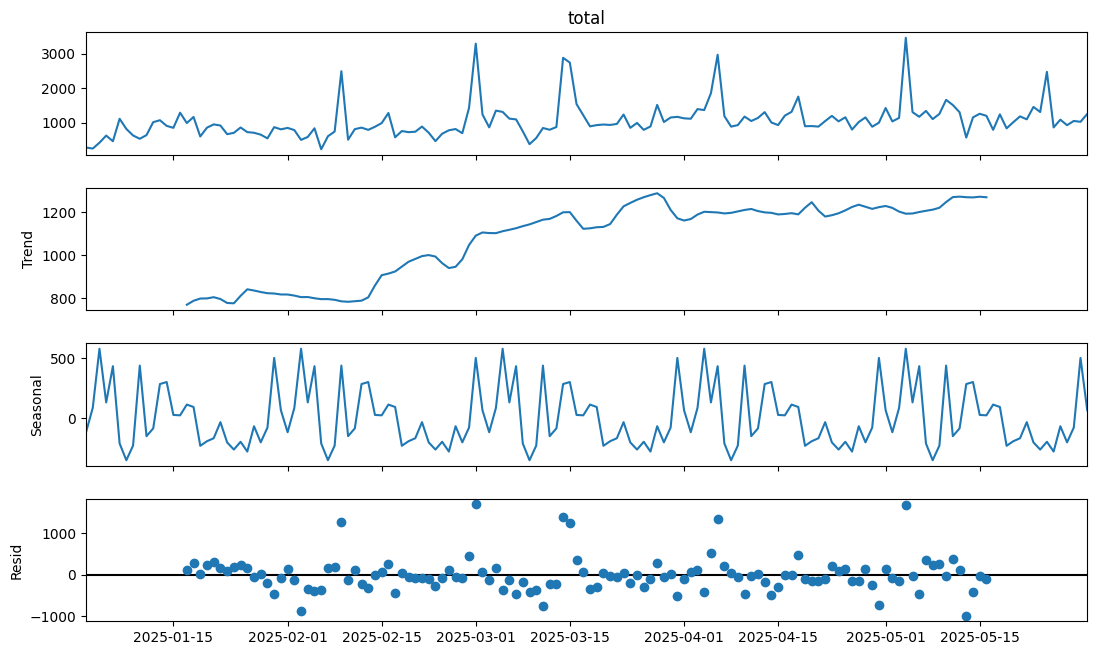

In [9]:
# Properties of temporal series (monthly)
result = seasonal_decompose(sales_per_date, model='additive', period=30)
fig = result.plot()
fig.set_size_inches(12, 7)
plt.show()

There is a clear increasing monthly trend, along with indications of seasonality

## Brand behavior

Join sales with unit costs

In [10]:
# Join sales with unit costs
sales_with_cost = pd.merge(df_sales, df_inventory[['product_id', 'unit_cost']], on='product_id', how='left')
sales_with_cost['total_cost'] = sales_with_cost['quantity'] * sales_with_cost['unit_cost']

Properties of each brand

In [11]:
# Days in range
days_in_range = (sales_with_cost["sale_date"].max() - sales_with_cost["sale_date"].min()).days + 1
# Brand aggregation
sales_agg_brand = sales_with_cost.groupby("brand_id").agg(
    products_per_brand=("product_id", "nunique"),
    categories_per_brand=("category_id", "nunique"),
    days_with_sales=("sale_date", "nunique"),
    total_quantity_sold=("quantity", "sum"),
    total_revenue=("total", "sum"),
    total_cost=("total_cost", "sum")
)
sales_agg_brand['total_margin'] = sales_agg_brand['total_revenue'] - sales_agg_brand['total_cost']
sales_agg_brand['revenue_per_product'] = sales_agg_brand['total_revenue'] / sales_agg_brand['total_quantity_sold']
sales_agg_brand['margin_per_product'] = sales_agg_brand['total_margin'] / sales_agg_brand['total_quantity_sold']
sales_agg_brand.sort_values(by="total_margin", ascending=False)

,products_per_brand,categories_per_brand,days_with_sales,total_quantity_sold,total_revenue,total_cost,total_margin,revenue_per_product,margin_per_product
brand_id,,,,,,,,,
b_2,26,2,149,4432,97313,86406.858,10906.142,21.956904,2.460772
b_1,69,3,149,1665,42125,34430.812,7694.188,25.300300,4.621134
b_3,5,1,136,1670,16954,13366.484,3587.516,10.152096,2.148213


Visualize properties

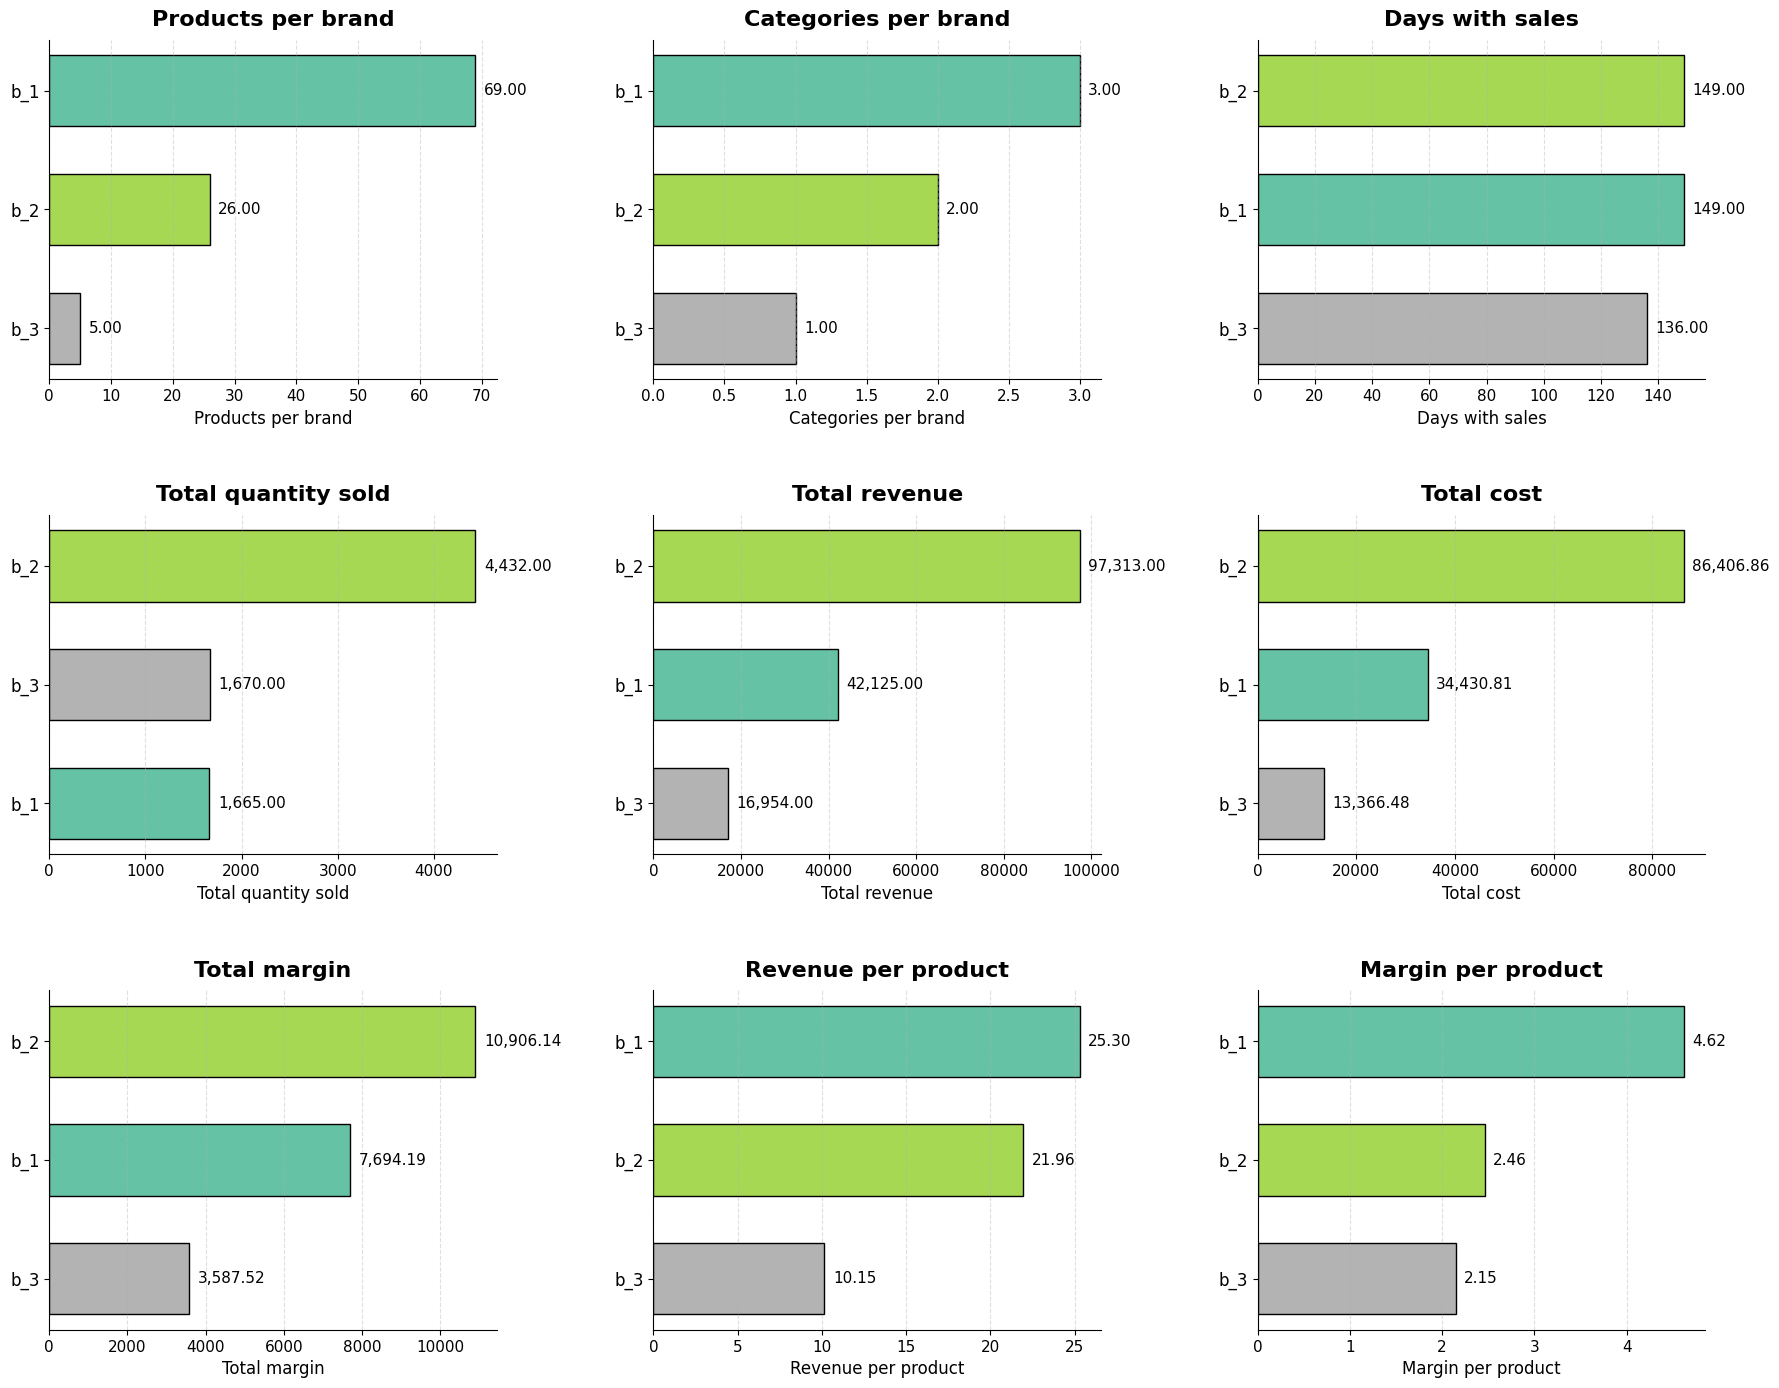

In [12]:
# Consistent colors by brand
brands = sorted(sales_agg_brand.index.unique())
palette = plt.cm.Set2(np.linspace(0, 1, len(brands)))
color_map = dict(zip(brands, palette))

# Columns to plot
cols_to_plot = [
    'products_per_brand',
    'categories_per_brand',
    'days_with_sales',
    'total_quantity_sold',
    'total_revenue',
    'total_cost',
    'total_margin',
    'revenue_per_product',
    'margin_per_product'
]

# Dynamic grid
n_cols = 3
n_rows = int(np.ceil(len(cols_to_plot) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 5))
axes = axes.flatten()

# Plot each column
for i, col in enumerate(cols_to_plot):
    ax = axes[i]
    # Sort ascending for visual consistency
    data_sorted = sales_agg_brand.sort_values(by=col, ascending=True)
    # Colors by category
    bar_colors = [color_map[c] for c in data_sorted.index]
    # Horizontal bar chart
    ax.barh(data_sorted.index, data_sorted[col], color=bar_colors,edgecolor='black',height=0.6)
    # Value labels
    for j, v in enumerate(data_sorted[col]):
        ax.text(
            v + data_sorted[col].max() * 0.02,  # right offset
            j,
            f'{v:,.2f}' if data_sorted[col].max() > 50 else f'{v:,.2f}',
            va='center',
            ha='left',
            fontsize=11
        )

    # General format
    ax.set_title(col.replace('_', ' ').capitalize(), fontsize=16, fontweight='bold', pad=10)
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=11)
    ax.grid(axis='x', linestyle='--', alpha=0.4)
    ax.set_xlabel(col.replace('_', ' ').capitalize(), fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Hide empty subplots
for ax in axes[len(cols_to_plot):]:
    ax.axis('off')
# Adjust margins
plt.subplots_adjust(left=0.06, right=0.98, top=0.93, bottom=0.07, wspace=0.35, hspace=0.4)
plt.show()

Compute trends

In [13]:
df_trends_brands = analyze_trend(df_sales, level_col='brand_id', date_col='sale_date', value_col='total')
df_trends_brands

,brand_id,trend,p_value
0,b_1,increasing,1.718071e-09
1,b_2,increasing,3.392346e-05
2,b_3,increasing,6.734635e-04


## Category behavior

Properties of each category

In [14]:
# Category aggregation
sales_agg_category = sales_with_cost.groupby("category_id").agg(
    products_per_category=("product_id", "nunique"),
    days_with_sales=("sale_date", "nunique"),
    total_quantity_sold=("quantity", "sum"),
    total_revenue=("total", "sum"),
    total_cost=("total_cost", "sum"),
)
sales_agg_category['total_margin'] = sales_agg_category['total_revenue'] - sales_agg_category['total_cost']
sales_agg_category['revenue_per_product'] = sales_agg_category['total_revenue'] / sales_agg_category['total_quantity_sold']
sales_agg_category['margin_per_product'] = sales_agg_category['total_margin'] / sales_agg_category['total_quantity_sold']
sales_agg_category.sort_values(by="total_margin", ascending=False)

,products_per_category,days_with_sales,total_quantity_sold,total_revenue,total_cost,total_margin,revenue_per_product,margin_per_product
category_id,,,,,,,,
c_2,25,149,4414,96719,85950.918,10768.082,21.911871,2.439529
c_6,66,149,1617,41409,33873.882,7535.118,25.608534,4.659937
c_4,5,136,1670,16954,13366.484,3587.516,10.152096,2.148213
c_5,1,34,46,688,534.520,153.480,14.956522,3.336522
c_1,1,9,18,594,455.940,138.060,33.000000,7.670000
c_3,2,2,2,28,22.410,5.590,14.000000,2.795000


Visualize properties

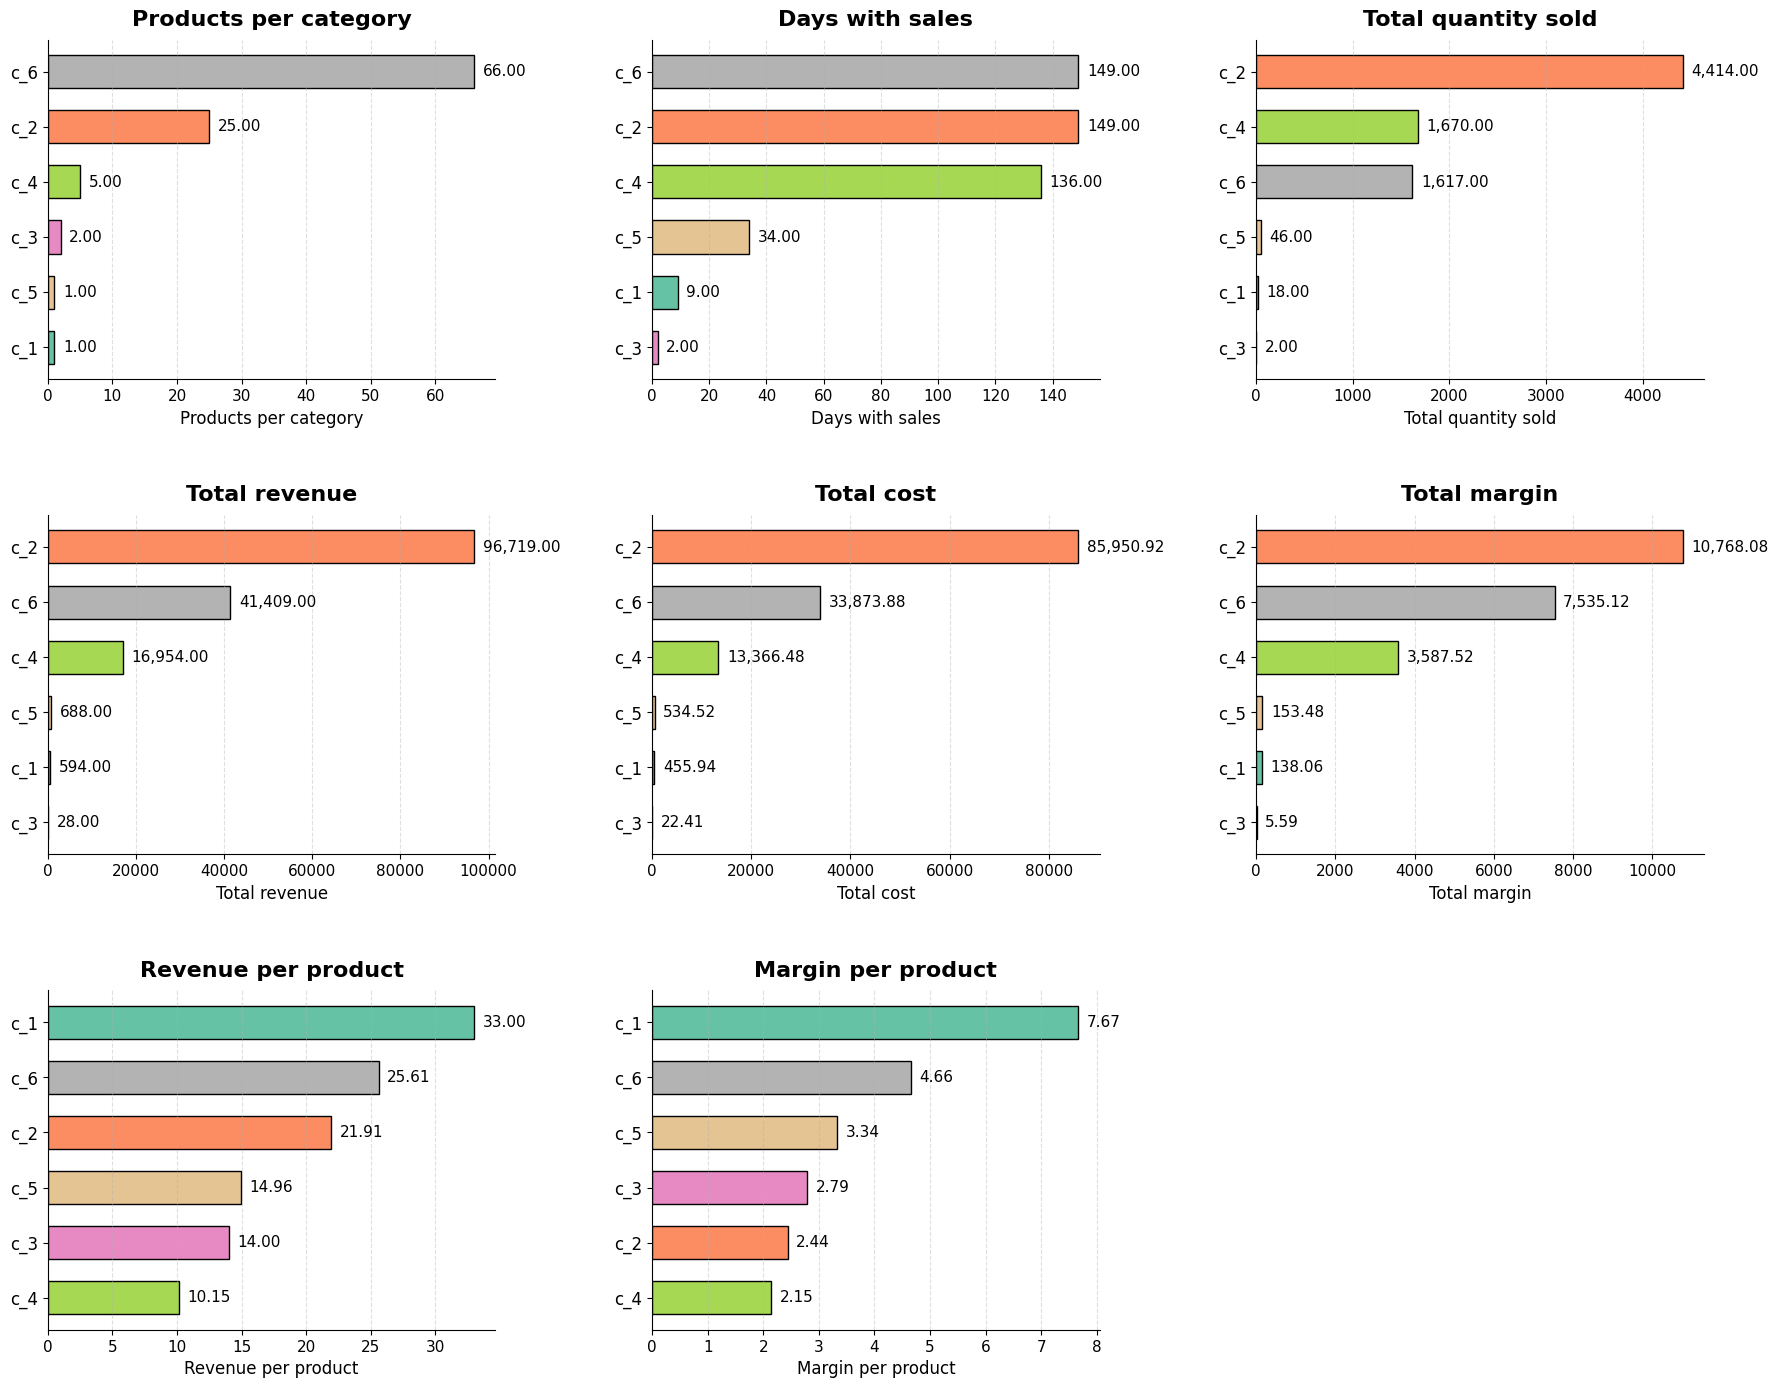

In [15]:
# Consistent colors by category
categories = sorted(sales_agg_category.index.unique())
palette = plt.cm.Set2(np.linspace(0, 1, len(categories)))
color_map = dict(zip(categories, palette))

# Columns to plot
cols_to_plot = [
    'products_per_category',
    'days_with_sales',
    'total_quantity_sold',
    'total_revenue',
    'total_cost',
    'total_margin',
    'revenue_per_product',
    'margin_per_product'
]

# Dynamic grid
n_cols = 3
n_rows = int(np.ceil(len(cols_to_plot) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 5))
axes = axes.flatten()

# Plot each column
for i, col in enumerate(cols_to_plot):
    ax = axes[i]
    # Sort ascending for visual consistency
    data_sorted = sales_agg_category.sort_values(by=col, ascending=True)
    # Colors by category
    bar_colors = [color_map[c] for c in data_sorted.index]
    # Horizontal bar chart
    ax.barh(data_sorted.index, data_sorted[col], color=bar_colors, edgecolor='black', height=0.6)

    # Value labels
    for j, v in enumerate(data_sorted[col]):
        ax.text(
            v + data_sorted[col].max() * 0.02,  # small right offset
            j,
            f'{v:,.2f}' if data_sorted[col].max() > 50 else f'{v:,.2f}',
            va='center',
            ha='left',
            fontsize=11
        )

    # General format
    ax.set_title(col.replace('_', ' ').capitalize(), fontsize=16, fontweight='bold', pad=10)
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=11)
    ax.grid(axis='x', linestyle='--', alpha=0.4)
    ax.set_xlabel(col.replace('_', ' ').capitalize(), fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Hide empty subplots
for ax in axes[len(cols_to_plot):]:
    ax.axis('off')

# Adjust margins
plt.subplots_adjust(left=0.06, right=0.98, top=0.93, bottom=0.07, wspace=0.35, hspace=0.4)
plt.show()

Compute trends

In [16]:
df_trends_categories = analyze_trend(df_sales, level_col='category_id', date_col='sale_date', value_col='total')
df_trends_categories

,category_id,trend,p_value
0,c_1,stable performance,6.303102e-01
1,c_2,increasing,8.637036e-05
2,c_3,insufficient data,NaN
3,c_4,increasing,6.734635e-04
4,c_5,increasing,4.538842e-02
5,c_6,increasing,2.561572e-09


## Product-level analysis

Properties of each product

In [17]:
# Product aggregation
sales_agg_product = df_sales.groupby("product_id").agg(
    days_with_sales=("sale_date", "nunique"),
    total_quantity_sold=("quantity", "sum"),
    total_revenue=("total", "sum"),
).reset_index().merge(df_inventory[["product_id", "unit_cost"]], on="product_id", how="left")
# Calculate total cost and margin
sales_agg_product['total_cost'] = sales_agg_product['total_quantity_sold'] * sales_agg_product['unit_cost']
sales_agg_product['total_margin'] = sales_agg_product['total_revenue'] - sales_agg_product['total_cost']
sales_agg_product.sort_values(by="total_margin", ascending=False)

,product_id,days_with_sales,total_quantity_sold,total_revenue,unit_cost,total_cost,total_margin
96,p_96,128,1452,7260,3.600,5227.200,2032.800
57,p_60,140,710,14200,17.535,12449.850,1750.150
85,p_86,92,216,9404,36.981,7987.896,1416.104
26,p_32,115,513,7540,12.750,6540.750,999.250
49,p_53,72,105,4935,39.255,4121.775,813.225
...,...,...,...,...,...,...,...
59,p_62,1,1,12,9.960,9.960,2.040
77,p_79,1,1,10,8.200,8.200,1.800
56,p_6,2,2,16,7.590,15.180,0.820
71,p_73,1,1,32,32.080,32.080,-0.080


Products that account for the the highest percentage of margin

In [18]:
# Calculate margin groups
margin_groups_products = assign_margin_groups(sales_agg_product, margin_col='total_margin')
labels = {1: '50%', 2: '75%', 3: '90%',4: '95%'}
for group, perc in labels.items():
    count = (margin_groups_products['group'] <= group).sum()
    print(f"\nApproximately {perc} of the margin is distributed across {count} products")


Approximately 50% of the margin is distributed across 10 products

Approximately 75% of the margin is distributed across 27 products

Approximately 90% of the margin is distributed across 48 products

Approximately 95% of the margin is distributed across 61 products


Visualize products and their margin-based groups

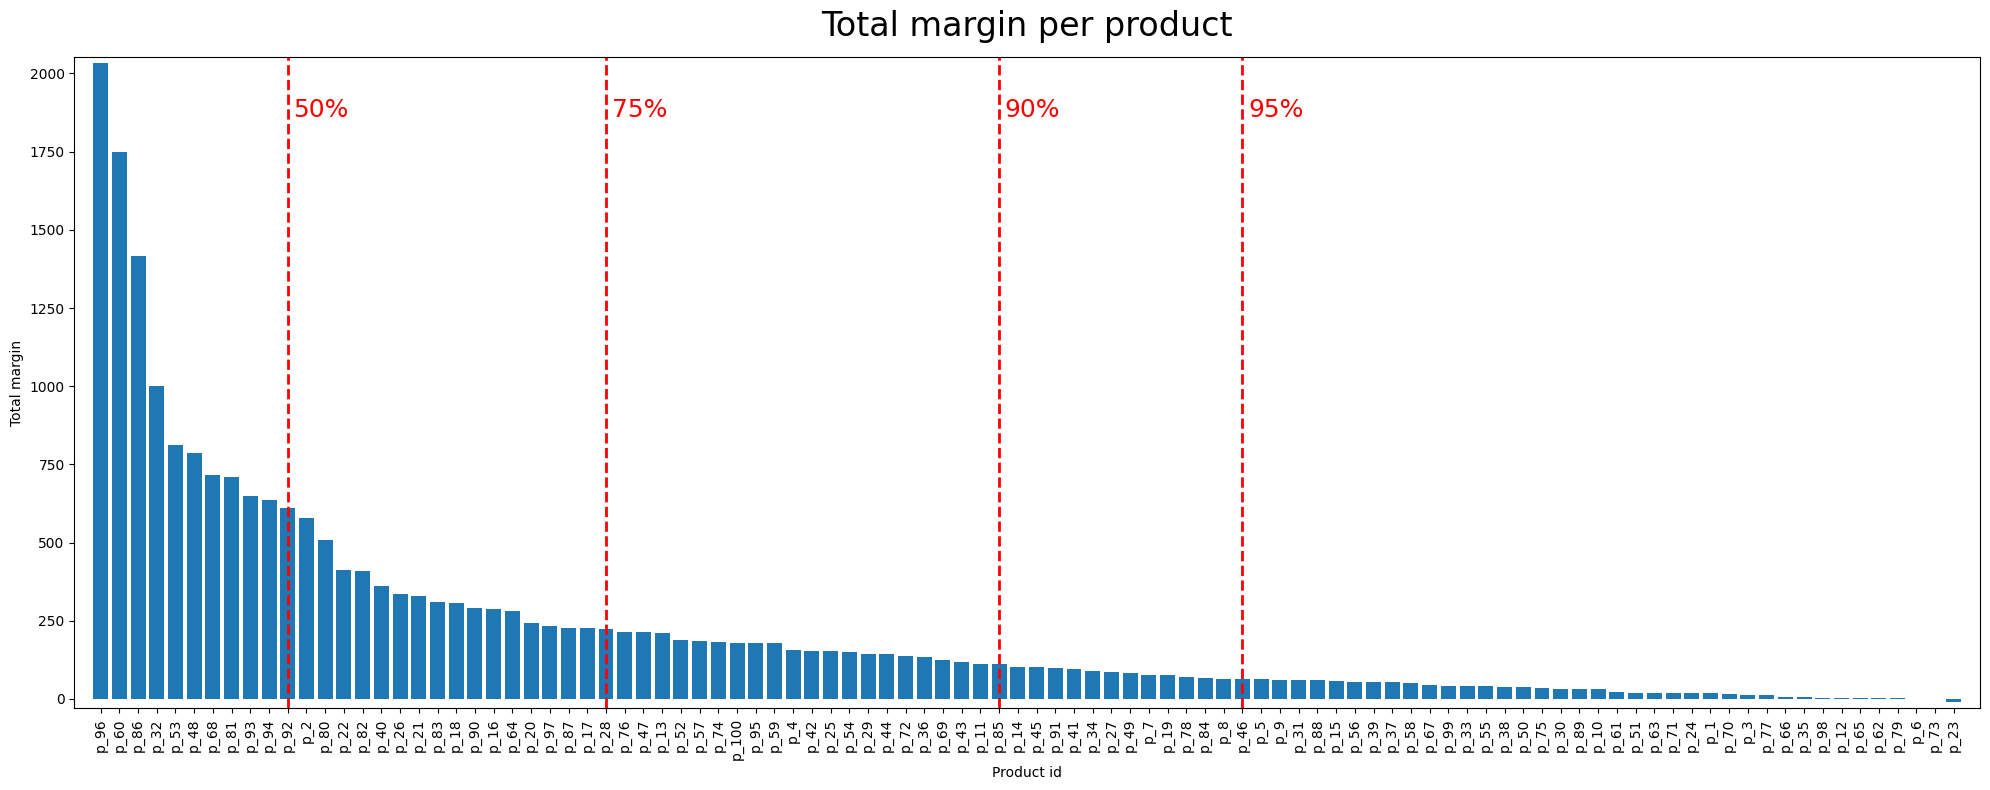

In [19]:
# Sort products by margin
sales_plot = margin_groups_products.sort_values('total_margin', ascending=False)

# Plot margins
plt.figure(figsize=(20, 8))
plt.bar(sales_plot['product_id'], sales_plot['total_margin'])
plt.xticks(rotation=90)
plt.xlabel('Product id')
plt.ylabel('Total margin')
plt.title('Total margin per product', fontsize=24, pad=15)

# Draw vertical lines according to group change
group_changes = sales_plot['group'].ne(sales_plot['group'].shift()).cumsum()
group_limits = sales_plot.groupby('group').size().cumsum().iloc[:-1]
for group, x_pos in group_limits.items():
    label = labels.get(group, "")
    plt.axvline(x=x_pos, color='red', linestyle='--', linewidth=2)
    plt.text(
        x_pos + 0.3,
        plt.ylim()[1] * 0.9,
        label,
        color='red',
        fontsize=18,
        rotation=0,
        va='top'
    )

# Adjust margins
plt.margins(x=0.01, y=0.01)
plt.tight_layout()
plt.show()

Products that generate losses

In [20]:
# Products with negative margin
products_negative_margin = sales_agg_product[sales_agg_product['total_margin'] < 0]
print(f"\nThere are {len(products_negative_margin)} products with losses (negative margin)")
products_negative_margin[['product_id', 'total_quantity_sold', 'total_revenue', 'total_cost', 'total_margin']]


There are 2 products with losses (negative margin)


,product_id,total_quantity_sold,total_revenue,total_cost,total_margin
16,p_23,9,253,263.07,-10.07
71,p_73,1,32,32.08,-0.08


Product trends

In [21]:
# Obtain trends
df_trends_products = analyze_trend(df_sales, level_col='product_id', date_col='sale_date', value_col='total')
margin_groups_products['group'] = margin_groups_products['group'].replace({1: 'High-value product', 2: 'Medium-value product', 3: 'Low-contribution product', 4: 'Marginal product', 5: 'Residual product'}).astype('object')

Combine trend data with the corresponding margin-based groups

In [22]:
# Combine dataframes with margin group and trend behavior
df_classification_products = pd.merge(margin_groups_products[['product_id', 'total_quantity_sold', 'total_revenue', 'total_cost', 'total_margin', 'group']], df_trends_products[['product_id', 'trend']], on='product_id', how='inner')
# General behavior
df_classification_products['general_behavior'] = df_classification_products['group'] + ' & ' + df_classification_products['trend']
# Products with negative margin
df_classification_products.loc[df_classification_products['total_margin'] < 0, 'general_behavior'] = 'Product with negative margin'

Visualize the distribution by strategic category

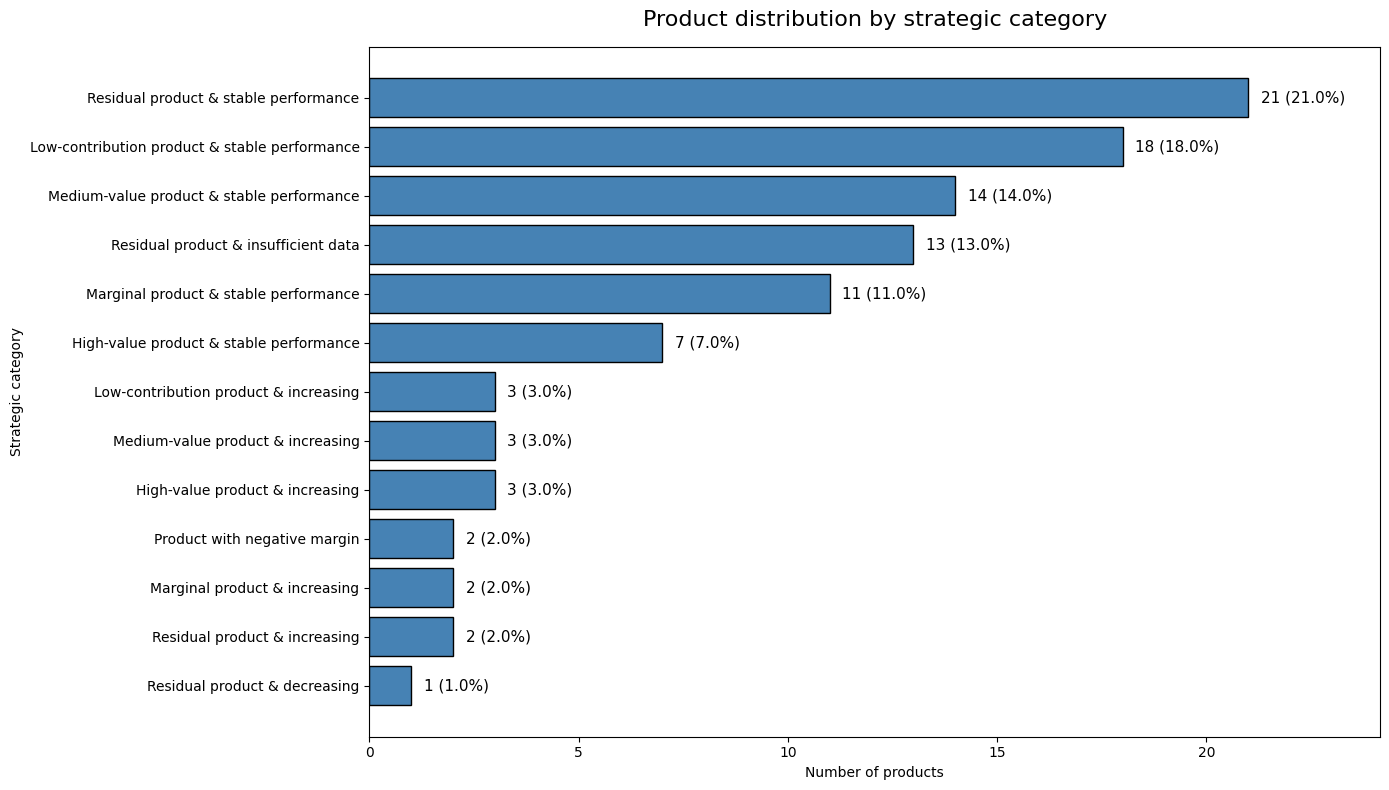

In [23]:
# Calculate accounts and percentages
counts = df_classification_products['general_behavior'].value_counts().sort_values(ascending=True)
percentages = counts / counts.sum() * 100

# Figure
plt.figure(figsize=(14, 8))
bars = plt.barh(counts.index, counts.values, color='steelblue', edgecolor='black')
# Labels and title
plt.xlabel('Number of products')
plt.ylabel('Strategic category')
plt.title('Product distribution by strategic category', fontsize=16, pad=15)

# Add counts and percentages
for i, (value, pct) in enumerate(zip(counts.values, percentages.values)):
    plt.text(value + 0.3, i, f"{value:,} ({pct:.1f}%)", va='center', fontsize=11, color='black')

# Adjust margins
plt.xlim(0, counts.max() * 1.15)
plt.tight_layout()
plt.show()

**Product Groups:**

High-value: Make up approximately 50% of the total margin

Medium-value: Represent the next 25% of the accumulated margin — together with high-value products, they account for 75% of the total margin

Low-contribution: Represent the next 15% of the accumulated margin — together with high- and medium-value products, they account for 90% of the total margin

Marginal: Represent the next 5% of the accumulated margin — together with the previously mentioned groups, they account for 95% of the total margin

Residual: Represent the final 5% of the accumulated margin — together with the other groups, they complete the total margin


**Trend Types:**

Increasing: Products with increasing sales

Decreasing: Products with decreasing sales

Stable performance: Products with no identifiable sales trend

Insufficient data: There is not enough sales data to estimate a trend


**Exceptions:**

Negative margin: Products whose sales revenue is lower than their costs

Identify price changes of the products throughout the date range

In [24]:
# Aggregate of sales with unit price
sales_agg_product_date = sales_with_cost.groupby(['sale_date', 'product_id']).agg(total_quantity_sold=("quantity", "sum"),
                                                                                  unit_price = ("unit_price", "max")).reset_index()

results_prices_change = []

for product_id, group in sales_agg_product_date.groupby('product_id'):
    group = group.sort_values('sale_date').set_index('sale_date')
    # Fill in days without sales with 0
    group = group.asfreq('D', fill_value=0).reset_index()
    prices = group['unit_price'].replace(0, None).ffill()
    group['unit_price'] = prices
    # Detect unique prices
    unique_prices = group['unit_price'].dropna().unique().astype(float)
    # Filter periods by price
    first_price = unique_prices[0]
    last_price = unique_prices[-1]
    sales_before = group[group['unit_price'] == first_price]['total_quantity_sold']
    sales_after  = group[group['unit_price'] == last_price]['total_quantity_sold']

    # If there are sufficient data to compare behavior before vs after
    if len(sales_before[sales_before!=0]) > 2 and len(sales_after[sales_after!=0]) > 2 and len(unique_prices) > 1:
        # Averages in the respective period
        avg_before = sales_before.mean()
        avg_after  = sales_after.mean()
        # Behaviors
        if first_price < last_price:
            direction = ('sold fewer products when the price increased' if avg_after < avg_before
                        else 'sold more products when the price increased' if avg_after > avg_before
                        else 'no change in product sales')
        else:
            direction = ('sold fewer products when the price decreased' if avg_after < avg_before
                        else 'sold more products when the price decreased' if avg_after > avg_before
                        else 'no change in product sales')

        results_prices_change.append({
            'product_id': product_id,
            'first_price': first_price,
            'last_price': last_price,
            'avg_quantity_first_price': round(avg_before, 2),
            'avg_quantity_last_price': round(avg_after, 2),
            'effect_price_change': direction
        })

    else:
        results_prices_change.append({
            'product_id': product_id,
            'first_price': first_price,
            'last_price': None,
            'avg_quantity_first_price': None,
            'avg_quantity_last_price': None,
            'effect_price_change': 'no change in price'
        })

df_results_prices_change = pd.DataFrame(results_prices_change)

In [25]:
# Join dataframe with product behavior with price change effects
df_results_product_behavior = df_classification_products.merge(df_results_prices_change, on='product_id', how='left')

Visualize the effect of price changes

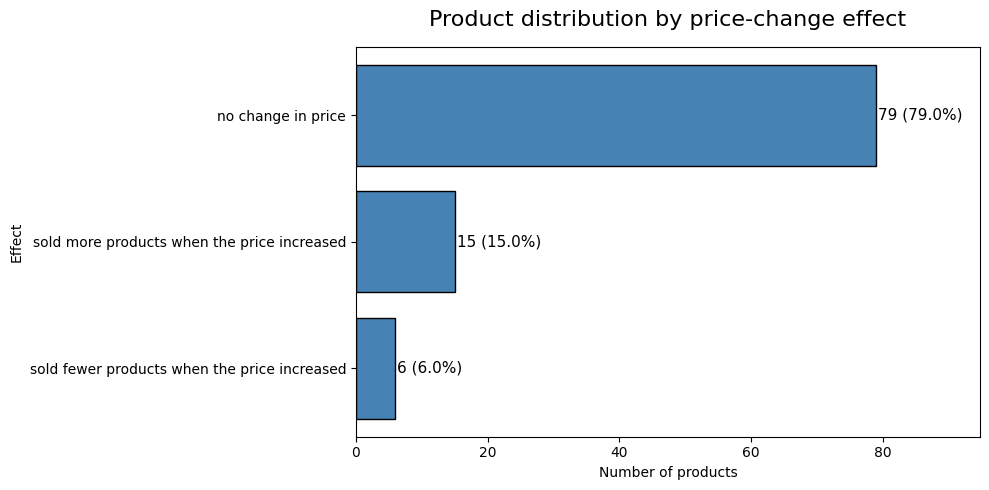

In [26]:
# Calculate accounts and percentages
counts = df_results_product_behavior['effect_price_change'].value_counts().sort_values(ascending=True)
percentages = counts / counts.sum() * 100

# Figure
plt.figure(figsize=(10, 5))
bars = plt.barh(counts.index, counts.values, color='steelblue', edgecolor='black')
# Labels and title
plt.xlabel('Number of products')
plt.ylabel('Effect')
plt.title('Product distribution by price-change effect', fontsize=16, pad=15)

# Add counts and percentages
for i, (value, pct) in enumerate(zip(counts.values, percentages.values)):
    plt.text(value + 0.3, i, f"{value:,} ({pct:.1f}%)", va='center', fontsize=11, color='black')

# Adjust margins
plt.xlim(0, counts.max() * 1.2)
plt.tight_layout()
plt.show()

Saving as CSV the data for each product: sales, costs, margins, trend, margin-based group, and the effect obtained from the price change

In [27]:
df_results_product_behavior.to_csv('../output/products_behavior.csv', encoding = 'utf-8-sig', index=False)

## Sales Forecasting

Since, when breaking down by product, there is a large number of zero-sales days for most products, sales for each product were aggregated weekly to reduce the number of gaps (zero values). Forecasts were generated to estimate how much each product will sell in the following intervals:

*   1 week
*   1 bi-week
*   1 month

Three approaches were used:

*   Prophet model: for products with more than 6 data points (sales) and where zero values do not exceed 40% of the observations
*   Croston model: for products with more than 6 data points (sales) and where zero values exceed 40% of the observations.
*   Mean calculation: for products with fewer than 6 data points (sales), as there is insufficient data to evaluate a forecasting model.

To evaluate the models, MAE and RMSE metrics were used. When analyzing and comparing errors, it is important to remember that we are predicting weekly sales, not daily sales.

In [28]:
# Sales per day per product
sales_product_date = sales_with_cost.groupby(['sale_date', 'product_id']).agg(total=("total", "sum")).reset_index()
total_metrics = []
total_predictions = []
model_used = []
# Iterate over each product
for product in sales_product_date['product_id'].unique():
    sales_product = sales_product_date[sales_product_date['product_id'] == product]
    # Fill missing dates
    min_date = sales_product['sale_date'].min()
    max_date = pd.Timestamp('2025-05-31 00:00:00')  # end date
    all_dates = pd.date_range(start=min_date, end=max_date, freq='D')
    sales_product = (
        sales_product
        .set_index('sale_date')
        .groupby('product_id')
        .apply(lambda g: g.reindex(all_dates, fill_value=0))
        .drop(columns='product_id', errors='ignore')
        .rename_axis(['product_id', 'sale_date'])
        .reset_index()
    )
    # Aggregate to weekly frequency
    sales_product = (
                sales_product.groupby(['product_id', pd.Grouper(key='sale_date', freq='W')])['total']
                .sum()
                .reset_index()
            )
    df_clean = sales_product[['sale_date', 'total']].rename(columns={'sale_date': 'ds', 'total': 'y'})

    # If there are less than 6 weeks, use 'mean' to predict
    if len(df_clean) <= 6:
        metrics_prod = {'product_id': product,'MAE': None,'RMSE': None}
        mean_prod = float(df_clean['y'].mean())
        predictions_prod = {'product_id': product, 'sales_next_week': mean_prod,'sales_next_biweek': 2*mean_prod,'sales_next_month': 4*mean_prod}
        model_used.append({'product_id': product, 'model': 'mean'})
    else:
        # If the zero data represents more than 40%, use croston model
        if (df_clean['y'] == 0).mean() > 0.4:
            metrics_prod = evaluate_croston(df_clean, product_name = product, smoothing=0.9)
            predictions_prod = forecast_full_croston(df_clean, product_name = product, smoothing=0.9)
            model_used.append({'product_id': product, 'model': 'croston'})
        # If the zero data represents less than 40%, use prophet model
        else:
            metrics_prod = evaluate_prophet(df_clean, product_name = product)
            predictions_prod = forecast_full_prophet(df_clean, product_name = product)
            model_used.append({'product_id': product, 'model': 'prophet'})

    total_metrics.append(metrics_prod)
    total_predictions.append(predictions_prod)

# Dataframes with results
df_models = pd.DataFrame(model_used)
df_metrics = pd.DataFrame(total_metrics)
df_predictions = pd.DataFrame(total_predictions)

# Clear prophet logs
clear_output()

Joining the forecast, metrics, and model-used dataframes together with the current inventory as of the cutoff date

In [29]:
# Products dataframe
df_products = df_inventory[['product_id', 'stock', 'unit_cost']]
df_unit_price = sales_with_cost.groupby(['product_id']).agg( unit_price = ("unit_price", "last")).reset_index()
# Dataframe with forecast
df_products_forecast = df_products.merge(df_unit_price, on='product_id', how='left').merge(df_models, on='product_id', how='left')
df_products_forecast = df_products_forecast.merge(df_metrics, on='product_id', how='left').merge(df_predictions, on='product_id', how='left')
# Obtain number of expected products
df_products_forecast['num_prod_per_week'] = np.round(df_products_forecast['sales_next_week'] / df_products_forecast['unit_price']).astype(int)
df_products_forecast['num_prod_per_biweek'] = np.round(df_products_forecast['sales_next_biweek'] / df_products_forecast['unit_price']).astype(int)
df_products_forecast['num_prod_per_month'] = np.round(df_products_forecast['sales_next_month'] / df_products_forecast['unit_price']).astype(int)
# Check if stock is sufficient
df_products_forecast['stock_next_week'] = np.where(df_products_forecast['stock'] > df_products_forecast['sales_next_week'], 'stock sufficient', 'stock insufficient')
df_products_forecast['stock_next_biweek'] = np.where(df_products_forecast['stock'] > df_products_forecast['sales_next_biweek'], 'stock sufficient', 'stock insufficient')
df_products_forecast['stock_next_month'] = np.where(df_products_forecast['stock'] > df_products_forecast['sales_next_month'], 'stock sufficient', 'stock insufficient')
# Sort by sales
df_products_forecast = df_products_forecast.sort_values(by='sales_next_week', ascending=False).reset_index(drop=True)

Overall error evaluation

In [30]:
max_mae = df_products_forecast['MAE'].max()
max_rmse = df_products_forecast['RMSE'].max()
mean_mae = df_products_forecast['MAE'].mean()
mean_rmse = df_products_forecast['RMSE'].mean()
print(f"The highest MAE for a product is: {max_mae:.1f} weekly - {max_mae/7:.1f} daily")
print(f"The highest RMSE for a product is: {max_rmse:.1f} weekly - {max_rmse/7:.1f} daily")
print(f"The average MAE across products is: {mean_mae:.1f} weekly - {mean_mae/7:.1f} daily")
print(f"The average RMSE across products is: {mean_rmse:.1f} weekly - {mean_rmse/7:.1f} daily")

The highest MAE for a product is: 361.3 weekly - 51.6 daily
The highest RMSE for a product is: 383.2 weekly - 54.7 daily
The average MAE across products is: 57.3 weekly - 8.2 daily
The average RMSE across products is: 66.8 weekly - 9.5 daily


Saving the CSV with the sales forecasts for each product and time window, including the number of products expected to be sold and whether the current stock is sufficient to cover the demand in each time window

In [31]:
df_products_forecast.to_csv('../output/products_forecast.csv', encoding = 'utf-8-sig', index=False)